# Fragestellung: relative Abweichung zwischen Soll- und Istwert > 5% für einzelne Produkte. Liegt die Ursache in einer "empfindlichen" Chemie oder in der Technik begründet? -> Erzeugung eines Dentrogrammes, bei größerem Einfluss des Faktors "Chemie" sollten die einzelnen Produkte in einem Dentrogramm nah beeinander gruppiert sein.

## Um unterschiedliche Produkte miteinander vergleichen zu können, müssen Prozessgrößen normiert werden

## 1. Einlesen der Daten

In [1]:
import pandas as pd
import numpy as np
import csv
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from datetime import date, datetime

In [2]:
# Daten einlesen
df=pd.read_csv("process_data_df11.csv", header=[0,1], na_values=['nan'],
sep=',',low_memory=False)

# Spalte ohne Information löschen
df2=df.drop(['Unnamed: 0_level_0'],axis=1)


df2.head()

/home/alpha/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


ps                                                             \
             ps    ps_datum ps_beschichtete_rollenlange_m ps_c_losung_wt_%   
0  cb031d4b18ff  2018-05-13                        4487.0             31.0   
1  cb031d4b18ff  2018-05-13                        4487.0             31.0   
2  cb031d4b18ff  2018-05-13                        4487.0             31.0   
3  cb031d4b18ff  2018-05-13                        4487.0             31.0   
4  cb031d4b18ff  2018-05-13                        4487.0             31.0   

                                                                       \
  ps_gap_micro_m ps_dicke_as_micro_m ps_dicke_1 ps_dicke_2 ps_dicke_3   
0          250.0               136.0      136.0      134.0      134.0   
1          250.0               136.0      136.0      134.0      134.0   
2          250.0               136.0      136.0      134.0      134.0   
3          250.0               136.0      136.0      134.0      134.0   
4          250.0               136.0      136.0      134.0      134.0   

              ...             qc                                            \
  ps_dicke_4  ... qc_flux_l/m2/h qc_a-value_l/m2/h/bar qc_b-value_m/s_10-6   
0      135.0  ...      40.286235              4.625285            3.678446   
1      135.0  ...      40.252401              4.621401            3.165247   
2      135.0  ...      39.718186              4.560067            3.170593   
3      135.0  ...      39.441426              4.528292            2.855092   
4      135.0  ...      39.731817              4.561632            2.810373   

                                                    Sollwerte  \
  qc_flux_m3/m2/day sum_of_scrap roll_position soll_salzr_abs   
0          0.966870          0.0     58.181818           99.5   
1          0.966058          0.0    116.363636           99.5   
2          0.953236          0.0    174.545455           99.5   
3          0.946594          0.0    232.727273           99.5   
4          0.953564          0.0    290.909091           99.5   

                                                      
  soll_permeatd_abs soll_salzr_rel soll_permeatd_rel  
0              36.2      -0.123927          1.707208  
1              36.2       0.083994          1.621790  
2              36.2       0.064419          0.273103  
3              36.2       0.186600         -0.425610  
4              36.2       0.213790          0.307515  

[5 rows x 347 columns]

In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118670 entries, 0 to 118669
Columns: 347 entries, (ps, ps) to (Sollwerte, soll_permeatd_rel)
dtypes: bool(7), float64(300), int64(4), object(36)
memory usage: 308.6+ MB


In [4]:
df3=df2.copy()

In [5]:
df3=df3.droplevel(level=0,axis=1)

## 2. Vorbereiten des Datensatzes für die Normierung

### 2.1 Entfernen von Spalten, die entweder keine Prozessgrößen während der Produktion waren (_ref, _richtwert) oder in denen keine fehlerhaften/abweichenden Prozessgrößen enthalten sein können (_median)      

In [6]:
df3=df3[df3.columns.drop(list(df3.filter(regex='_ref')))]
df3=df3[df3.columns.drop(list(df3.filter(regex='_richtwert_')))]
df3=df3[df3.columns.drop(list(df3.filter(regex='_median')))]

### 2.2 Entfernen von Spalten, die zwar typ: int oder typ: float sind, deren Normierung jedoch physikalisch nicht sinnvoll ist

In [7]:
dropList = ['qc_maximalersalzrueckhalt','qc_breite','sc_d_links_anz_max','sc_d_rechts_anz_min',
            'sc_d_rechts_anz_max','qc_barcode_leak_test_values', 'ps','pa_coating','nr','pa_mpda_lsg','pa_chlorlsg','pa_sbs_lsg',
            'pa_alkalilsg','p_product_size','p_effective_area_per_leaf_m2','p_product_type','pp_actual_product',
           'pp_actual_product_short_name','pp_plan_ausbeute_elemente', 'pp_plan_product', 'pp_product_short_name',
           'qc_p_position','roll_position','winding_product_short_name','winding_product_type','assembled_in_elements_m', 'winding_product_line']

df4 = df3.copy()
for i in dropList:
    df4.drop(i, axis = 1, inplace = True)
# qc_maximalersalzruckhalt : just two values 0 and 99.99 
# qc_breite : just two values 985 and 0
# sc_d_links_anz_max : because has 118639 zero values (0.04 % are not zero)
# sc_d_rechts_anz_min : has 118674 (> 99.9%) zeros
# sc_d_rechts_anz_max  : has 118528 (99.9%) zeros
# qc_barcode_leak_test : categorical variable not fully understood
# ps : categorical variable not fully understood
# pa_coating : dummy variable
# nr : not necessary for linear regression
# all ending with lsg : seems to be container numbers for the reaction solution, no details are known about these containers
# p_product_size [1.4646, 1.3914, 0] is a recoding of p_effective_area_per_leaf_m2 [8, 4, 0]
# p_product_full_name : categorical variable, which contains same information as p_product_type
# p_product_type : renamed with more clear name aka B400 ULP, therefore dropped
# all pp_ : are subsets of categorical variables of p_product
# qc_p_position','roll_position','winding_product_short_name','winding_product_type' all categorical variable




In [8]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118670 entries, 0 to 118669
Columns: 285 entries, ps_datum to soll_permeatd_rel
dtypes: bool(7), float64(250), int64(3), object(25)
memory usage: 252.5+ MB


### 2.3 Mittelung von Spalten, welche dieselbe Prozessgröße innerhalb einer Charge beschreiben, allerdings an unterschiedlichen Positionen gemessen

##### Bsp: pa_air-knife_vor_amin_bad_Xm_%
- Messung erfolgt alle X-Meter
- müsste eigentlich eine Spalte sein, allerdings stimmen die Messpositionen nicht mit denen der Spalte roll_position überein,, welche die Messung einer Charge in der qc beschreibt -> Werte sind deshalb gekippt und kommen über mehrere Spalten vor
- Werte unterscheiden sich innerhalb einer Charge kaum
- Mittelwert hinreichend genau

##### Verfälschen das Ergebnis des Clusterings, da diese Prozessgröße im Vergleich zu einder anderen mehrfach mit berücksichtigt werden würde 


#### 2.3.1 Identifizierung einer Charge

In [9]:
df5=df4.copy()

In [10]:
## Liste mit allen Produktnamen für die folgenden Iterationen 
produktnamen=['c807697b3c7e','a79cf6a73839','f22a7fef71c5','c13b2f69d3c1','3e94b7067349','3394d82edc97','df9e75b29918','316c8d1ffca1','5661014763c8','73928f2577b5','22227b31350f','df1d09e643af','e2b1e6e1d5f5','54b98d0fe2eb','ff16223eb2bf','0cc0ba87b12f','a640f68db89c','b3ccc5e5f9b5','2256f65c362b','33d21930e431','3a0c28c7fc8c','630448a85ca3']

In [11]:
# Produktname merken, um zunächst alle produzierte Produkt zu identifizieren
df5=df5.set_index('p_product_full_name')

In [12]:
# Ein Prozessschritt findet jeweils an einem Tag statt -> Vergleich der Daten ermöglicht Chargenidentifizierung
date_format="%Y-%m-%d"


In [13]:
# Iteration mittels iloc -> Herausfinden Nummer der neuen Spalte p_full_name_count
df5['p_full_name_count']="AAAA"
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118670 entries, b3ccc5e5f9b5 to b3ccc5e5f9b5
Columns: 285 entries, ps_datum to p_full_name_count
dtypes: bool(7), float64(250), int64(3), object(25)
memory usage: 253.4+ MB


In [14]:
df5.iloc[1,284]

'AAAA'

In [15]:
# for-Schleife geht nacheinander alle Produkte durch
# while Schleife geht nacheinander alle Reihen durch und vergleicht das Datum -> unterschiedliches Datum <-> unterschiedliche Charge eines Produktes
df_cp=pd.DataFrame()

for name in range(len(produktnamen)):
    
    df_c=df5.loc[produktnamen[name]]
    i=0
    df_c_rows=df_c.shape[0]
    
    while i<df_c_rows:
        
        if i==0:
            
            # j beschreibt, wieviele Chargen eines Produktes bisher identifiziert wurden
            j=1
            df_c.iloc[i,284]=produktnamen[name]+"_"+str(j)
            print(df_c.iloc[i,284])
            
        elif abs((datetime.strptime(df_c.iloc[i]['ps_datum'], date_format)-datetime.strptime(df_c.iloc[i-1]['ps_datum'], date_format)).days)==0:
            df_c.iloc[i,284]=produktnamen[name]+"_"+str(j)
            
        else:
            j=j+1
            df_c.iloc[i,284]=produktnamen[name]+"_"+str(j)
            
        i=i+1
        
    df_cp=df_cp.append(df_c)
    
            
    

c807697b3c7e_1


/home/alpha/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


a79cf6a73839_1
f22a7fef71c5_1
c13b2f69d3c1_1
3e94b7067349_1
3394d82edc97_1
df9e75b29918_1
316c8d1ffca1_1
5661014763c8_1
73928f2577b5_1
22227b31350f_1
df1d09e643af_1
e2b1e6e1d5f5_1
54b98d0fe2eb_1
ff16223eb2bf_1
0cc0ba87b12f_1
a640f68db89c_1
b3ccc5e5f9b5_1
2256f65c362b_1
33d21930e431_1
3a0c28c7fc8c_1
630448a85ca3_1


In [16]:
df_cp.to_csv('process_data_df12.csv')

In [17]:
df_cp=pd.read_csv("process_data_df12.csv", na_values=['nan'],
sep=',',low_memory=False)

#### 2.3.2 Mittelung

In [18]:
l_prod_count=df_cp['p_full_name_count'].tolist()

In [19]:
df6=df_cp.copy()

In [20]:
df6=df6.set_index('p_full_name_count')


In [21]:
l_prod_count2=l_prod_count.copy()

In [22]:
#Duplikate entfernen
l_prod_count2=list(dict.fromkeys(l_prod_count2))

In [23]:
# Multiple Measurment columns
meanList = ['pa_cm-pda','pa_chlorkonzentration','pa_air-knife_vor_amin_bad','airknife_vor_amin_trockner',
            'pa_amin-trockner_feuchtigkeit_danfugt_bs','pa_amin-trockner_feuchtigkeit_danfugt_as','pa_amin-trockner_feuchtigkeit_cofely',
            'ps_dicke','ps_bad_temperatur','ps_auftragswerk_feuchtigkeit','sc_d_links_werte','sc_d_rechts_werte']


# Funktion to drop multiple measurment values
def MeanColumnCreate(meanList, df):
    for i in meanList:
        filterdf = df.filter(regex = i)
        name = i+"_mean"
        df.loc[:,name] = filterdf.mean(axis = 1)
        df.drop(filterdf, axis = 1, inplace = True)



In [24]:
df_mean=pd.DataFrame()

for charge in range(len(l_prod_count2)):
    df_c=df6.loc[l_prod_count2[charge]]
    MeanColumnCreate(meanList, df_c)
    df_mean=df_mean.append(df_c)
    

/home/alpha/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/alpha/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
df_mean

p_product_full_name    ps_datum  \
p_full_name_count                                   
c807697b3c7e_1           c807697b3c7e  2018-02-09   
c807697b3c7e_1           c807697b3c7e  2018-02-09   
c807697b3c7e_1           c807697b3c7e  2018-02-09   
c807697b3c7e_1           c807697b3c7e  2018-02-09   
c807697b3c7e_1           c807697b3c7e  2018-02-09   
...                               ...         ...   
630448a85ca3_48          630448a85ca3  2018-11-12   
630448a85ca3_48          630448a85ca3  2018-11-12   
630448a85ca3_48          630448a85ca3  2018-11-12   
630448a85ca3_48          630448a85ca3  2018-11-12   
630448a85ca3_48          630448a85ca3  2018-11-12   

                   ps_beschichtete_rollenlange_m  ps_c_losung_wt_%  \
p_full_name_count                                                    
c807697b3c7e_1                            4517.0              31.0   
c807697b3c7e_1                            4517.0              31.0   
c807697b3c7e_1                            4517.0              31.0   
c807697b3c7e_1                            4517.0              31.0   
c807697b3c7e_1                            4517.0              31.0   
...                                          ...               ...   
630448a85ca3_48                           4519.0              31.0   
630448a85ca3_48                           4519.0              31.0   
630448a85ca3_48                           4519.0              31.0   
630448a85ca3_48                           4519.0              31.0   
630448a85ca3_48                           4519.0              31.0   

                   ps_gap_micro_m  ps_raum_temperatur_start_c  \
p_full_name_count                                               
c807697b3c7e_1              280.0                        25.0   
c807697b3c7e_1              280.0                        25.0   
c807697b3c7e_1              280.0                        25.0   
c807697b3c7e_1              280.0                        25.0   
c807697b3c7e_1              280.0                        25.0   
...                           ...                         ...   
630448a85ca3_48             250.0                        24.0   
630448a85ca3_48             250.0                        24.0   
630448a85ca3_48             250.0                        24.0   
630448a85ca3_48             250.0                        24.0   
630448a85ca3_48             250.0                        24.0   

                   ps_auftragsbank_temperatur_start_c  \
p_full_name_count                                       
c807697b3c7e_1                                   19.0   
c807697b3c7e_1                                   19.0   
c807697b3c7e_1                                   19.0   
c807697b3c7e_1                                   19.0   
c807697b3c7e_1                                   19.0   
...                                               ...   
630448a85ca3_48                                  18.0   
630448a85ca3_48                                  18.0   
630448a85ca3_48                                  18.0   
630448a85ca3_48                                  18.0   
630448a85ca3_48                                  18.0   

                   ps_raum-feuchtigkeit_start_% ps_datum_coating  ps_out_m  \
p_full_name_count                                                            
c807697b3c7e_1                             44.0       2018-02-09    4517.0   
c807697b3c7e_1                             44.0       2018-02-09    4517.0   
c807697b3c7e_1                             44.0       2018-02-09    4517.0   
c807697b3c7e_1                             44.0       2018-02-09    4517.0   
c807697b3c7e_1                             44.0       2018-02-09    4517.0   
...                                         ...              ...       ...   
630448a85ca3_48                            50.0       2018-11-11    4519.0   
630448a85ca3_48                            50.0       2018-11-11    4519.0   
630448a85ca3_48                            50.0  

In [26]:
df_mean.to_csv('process_data_df13.csv')

In [27]:
df_mean=pd.read_csv("process_data_df13.csv", na_values=['nan'],
sep=',',low_memory=False)

In [28]:
df7=df_mean.copy()

In [29]:
df7=df_mean.set_index('p_full_name_count')

### 2.4 Typfilterung

In [30]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118654 entries, c807697b3c7e_1 to 630448a85ca3_48
Columns: 182 entries, p_product_full_name to sc_d_rechts_werte_mean
dtypes: bool(7), float64(147), int64(3), object(25)
memory usage: 160.1+ MB


In [31]:
# alle Prozessgrößen müssen Zahlen (int, float) sein
# Entfernen von allem, was keine Zahl ist

df7=df7.select_dtypes(include=['float64','int']) 

In [32]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118654 entries, c807697b3c7e_1 to 630448a85ca3_48
Columns: 150 entries, ps_beschichtete_rollenlange_m to sc_d_rechts_werte_mean
dtypes: float64(147), int64(3)
memory usage: 136.7+ MB


## 3. Normierung

In [33]:
# Liste mit allem Produktnamen 
# -> dient als Filter für Iteration
#produktnamen=['a79cf6a73839']
produktnamen=['a79cf6a73839','c807697b3c7e','f22a7fef71c5','c13b2f69d3c1','3e94b7067349','3394d82edc97','df9e75b29918','316c8d1ffca1','5661014763c8','73928f2577b5','22227b31350f','df1d09e643af','e2b1e6e1d5f5','54b98d0fe2eb','ff16223eb2bf','0cc0ba87b12f','a640f68db89c','b3ccc5e5f9b5','2256f65c362b','33d21930e431','3a0c28c7fc8c','630448a85ca3']

In [50]:
# Erzeugen eines leeren DataFrames, in welches die normierten Werte eingetragen werden
df_norm=pd.DataFrame()

for i in range(len(produktnamen)):
    
    # 1.Filtern nach Produktname und Erzeugen eines DataFrames, in welchem die Normierung erfolgt
    # !! Index ändert sich !!
    #to_norm=df3['p_product_full_name']==produktnamen[i]
    #df_n=df3[to_norm]
    df_n=df7.filter(like=produktnamen[i],axis=0)
    
    # 2. Merken von Größen, welche nicht normieret werden können (product_name) oder es bereits sind (relative Werte)
    # !! Gleicher Index für diese Größen für df_n und df_n2 
    #  -> können später problemlos wieder angefügt werden
    df_n2=df_n.copy()
    df_n=df_n.drop(columns=['soll_salzr_rel', 'soll_permeatd_rel'])
    
    # Wahl der Normierungsmethode
    # !! Normierung jeweils füra alle Chargen eines Produktes !! Einheitliche Bedingungen für ein Produkt
    df_n=(df_n-df_n.min())/(df_n.max()-df_n.min())
    #df_n=(df_n-df_n.mean())/df_n.std()
    
    # Anfügen der Größen, welche nicht normiert werden sollen
    # sowie sukzessives Einfügen der normierten DataFrames in das leere DataFrame df_norm
    
    df_n['soll_salzr_rel']=df_n2['soll_salzr_rel']
    df_n['soll_permeatd_rel']=df_n2['soll_permeatd_rel']
    
    df_norm=df_norm.append(df_n, ignore_index=False)
    


In [51]:
df8=df_norm.copy()

In [52]:
# Filtert man das DataFrame nach den verschiedenen Produktname, treten Konstanten Spalten auf (z.B. ps_c_losung_wt_%)
# -> Annahme: Es handelt sich dabei um spezifische Vorgaben für die Produktion eines jeweiligen Produktes (weil sie eben nicht über im kompletten DataFrame konstant sind)
# -> Erzeugen NaN-Einträge, da beim Normieren durch 0 geteilt wird (df_n.max()=df_n.min())
#  -> Müssen Entfernt werden, da uns Schwankungen einzelner Prozessgrößen innerhalb eines Produktes interessieren

df8=df8.dropna(axis='columns', how='any')

In [53]:
df8

ps_beschichtete_rollenlange_m  ps_out_m  ps_scrap_%  \
p_full_name_count                                                        
a79cf6a73839_1                          1.000000   1.00000    0.000000   
a79cf6a73839_1                          1.000000   1.00000    0.000000   
a79cf6a73839_1                          1.000000   1.00000    0.000000   
a79cf6a73839_1                          1.000000   1.00000    0.000000   
a79cf6a73839_1                          1.000000   1.00000    0.000000   
...                                          ...       ...         ...   
630448a85ca3_48                         0.988792   0.99644    0.011208   
630448a85ca3_48                         0.988792   0.99644    0.011208   
630448a85ca3_48                         0.988792   0.99644    0.011208   
630448a85ca3_48                         0.988792   0.99644    0.011208   
630448a85ca3_48                         0.988792   0.99644    0.011208   

                   pa_beschichtete_rollenlange_m  pa_raum_temperatur_start_c  \
p_full_name_count                                                              
a79cf6a73839_1                          1.000000                         1.0   
a79cf6a73839_1                          1.000000                         1.0   
a79cf6a73839_1                          1.000000                         1.0   
a79cf6a73839_1                          1.000000                         1.0   
a79cf6a73839_1                          1.000000                         1.0   
...                                          ...                         ...   
630448a85ca3_48                         0.964769                         0.0   
630448a85ca3_48                         0.964769                         0.0   
630448a85ca3_48                         0.964769                         0.0   
630448a85ca3_48                         0.964769                         0.0   
630448a85ca3_48                         0.964769                         0.0   

                   pa_temperatur_n-decan-lsg_chem_vorbereitung_start_c  \
p_full_name_count                                                        
a79cf6a73839_1                                              0.000000     
a79cf6a73839_1                                              0.000000     
a79cf6a73839_1                                              0.000000     
a79cf6a73839_1                                              0.000000     
a79cf6a73839_1                                              0.000000     
...                                                              ...     
630448a85ca3_48                                             0.207547     
630448a85ca3_48                                             0.207547     
630448a85ca3_48                                             0.207547     
630448a85ca3_48                                             0.207547     
630448a85ca3_48                                             0.207547     

                   pa_temperatur_alkali-lsg_chem_vorbereitung_start_c  \
p_full_name_count                                                       
a79cf6a73839_1                                              0.000000    
a79cf6a73839_1                                              0.000000    
a79cf6a73839_1                                              0.000000    
a79cf6a73839_1                                              0.000000    
a79cf6a73839_1                                              0.000000    
...                                                              ...    
630448a85ca3_48                                             0.047619    
630448a85ca3_48                                             0.047619    
630448a85ca3_48                                             0.047619    
630448a85ca3_48                                             0.047619    
630448a85ca3_48                                             0.047619    

                   pa_raum_feuchte_start_%  pa_vertikale_feuchte_oben_start_%  \
p_full_name_count    

## 4. Auswählen der Daten und Erzeugung eines Dentrogrammes

### 4.1 Salzrückhalt

#### 4.1.1 Filterkriterium

In [54]:

df9=df8[(df8['soll_salzr_rel']<-10) & (df8['soll_salzr_rel']>-100)]

In [55]:
# Jeder 1000 Eintrag hat eine Abweichung größer als 5%
df9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, a79cf6a73839_1 to 630448a85ca3_40
Data columns (total 57 columns):
ps_beschichtete_rollenlange_m                          148 non-null float64
ps_out_m                                               148 non-null float64
ps_scrap_%                                             148 non-null float64
pa_beschichtete_rollenlange_m                          148 non-null float64
pa_raum_temperatur_start_c                             148 non-null float64
pa_temperatur_n-decan-lsg_chem_vorbereitung_start_c    148 non-null float64
pa_temperatur_alkali-lsg_chem_vorbereitung_start_c     148 non-null float64
pa_raum_feuchte_start_%                                148 non-null float64
pa_vertikale_feuchte_oben_start_%                      148 non-null float64
pa_vertikale_feuchte_oben_mitte_%                      148 non-null float64
pa_ndecan/tmc                                          148 non-null float64
pa_out_m                               

In [56]:
df9=df9.reset_index()
prod_appearance=df9['p_full_name_count'].tolist()
df9

p_full_name_count  ps_beschichtete_rollenlange_m  ps_out_m  ps_scrap_%  \
0      a79cf6a73839_1                       1.000000  1.000000    0.000000   
1      a79cf6a73839_2                       0.000000  0.000000    1.000000   
2      a79cf6a73839_2                       0.000000  0.000000    1.000000   
3      a79cf6a73839_2                       0.000000  0.000000    1.000000   
4      a79cf6a73839_2                       0.000000  0.000000    1.000000   
..                ...                            ...       ...         ...   
143    630448a85ca3_3                       0.915318  0.973101    0.084682   
144   630448a85ca3_10                       0.971357  0.990902    0.028643   
145   630448a85ca3_22                       0.983811  0.994858    0.016189   
146   630448a85ca3_30                       0.845579  0.950949    0.154421   
147   630448a85ca3_40                       0.940224  0.981013    0.059776   

     pa_beschichtete_rollenlange_m  pa_raum_temperatur_start_c  \
0                         1.000000                    1.000000   
1                         0.000000                    0.000000   
2                         0.000000                    0.000000   
3                         0.000000                    0.000000   
4                         0.000000                    0.000000   
..                             ...                         ...   
143                       0.954117                    0.666667   
144                       0.959033                    0.666667   
145                       0.980746                    0.666667   
146                       0.941827                    0.833333   
147                       0.948382                    0.833333   

     pa_temperatur_n-decan-lsg_chem_vorbereitung_start_c  \
0                                             0.000000     
1                                             1.000000     
2                                             1.000000     
3                                             1.000000     
4                                             1.000000     
..                                                 ...     
143                                           0.811321     
144                                           0.962264     
145                                           0.767925     
146                                           0.358491     
147                                           0.509434     

     pa_temperatur_alkali-lsg_chem_vorbereitung_start_c  \
0                                             0.000000    
1                                             1.000000    
2                                             1.000000    
3                                             1.000000    
4                                             1.000000    
..                                                 ...    
143                                           0.714286    
144                                           0.523810    
145                                           0.680952    
146                                           0.757143    
147                                           0.619048    

     pa_raum_feuchte_start_%  pa_vertikale_feuchte_oben_start_%  ...  \
0                   1.000000                           1.000000  ...   
1                   0.000000                           0.000000  ...   
2                   0.000000                           0.000000  ...   
3                   0.000000                           0.000000  ...   
4                   0.000000                           0.000000  ...   
..                       ...                                ...  ...   
143                 0.315789                           0.047222  ...   
144                 0.921053                           0.069444  ...   
145                 0.000000                           0.008333  ...   
146                 0.131579                           0.038889  ...   
147                 0.078947                        

In [57]:
df9=df9.drop(['p_full_name_count'], axis=1)
df_norm_dendro=df9.to_numpy()
df_norm_dendro

array([[ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -1.02029547e+01,  2.67556143e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00, -1.12735865e+01,  1.75676827e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00, -1.01955265e+01,  2.32456985e+01],
       ...,
       [ 9.83810710e-01,  9.94857595e-01,  1.61892902e-02, ...,
         4.81605351e-01, -8.68572806e+01,  9.29371991e+01],
       [ 8.45579078e-01,  9.50949367e-01,  1.54420922e-01, ...,
         5.25083612e-01, -2.64560811e+01,  3.50440159e+01],
       [ 9.40224159e-01,  9.81012658e-01,  5.97758406e-02, ...,
         4.81605351e-01, -8.49639171e+01,  7.01543564e+01]])

In [58]:
mergings=linkage(df_norm_dendro, method='complete')

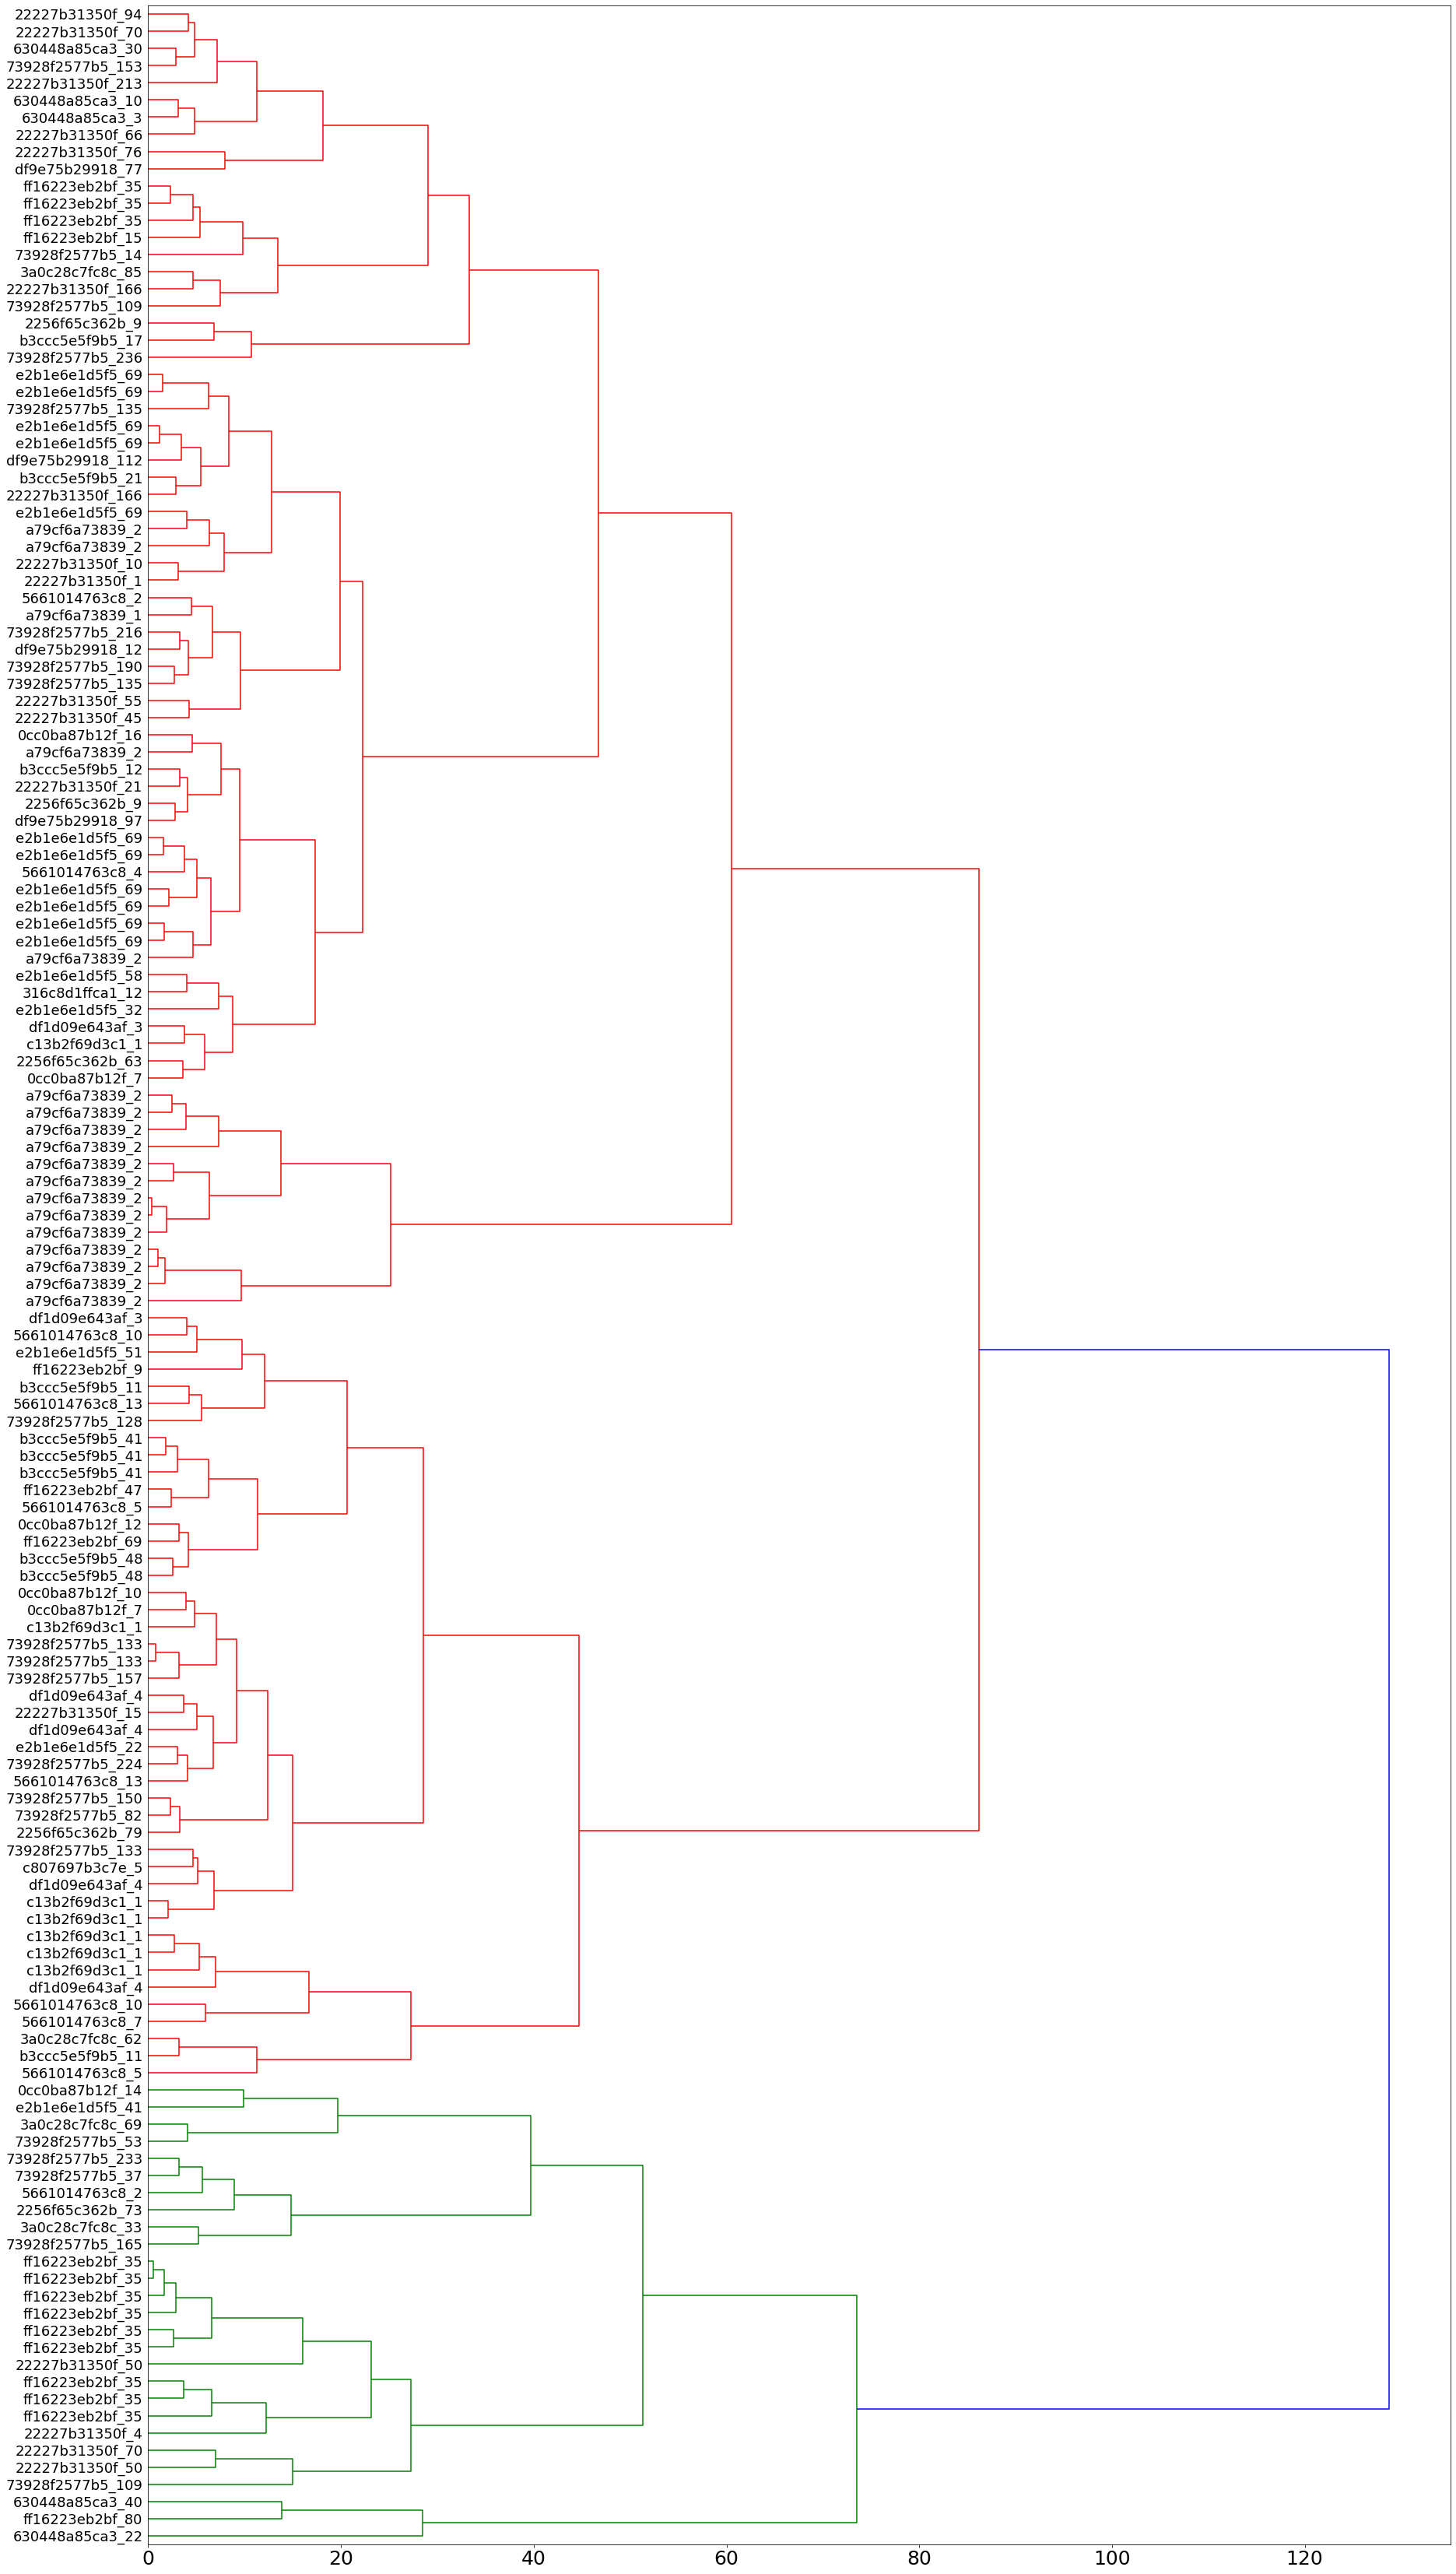

In [60]:
plt.figure(figsize=(30,60))
p=dendrogram(mergings,labels=prod_appearance, leaf_rotation=0, leaf_font_size=26, orientation='right')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=18)
plt.savefig('dendro_norm.pdf')